In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()

def loss(outputs, targets):
    return pose.pose_ce_loss(outputs[1], targets)

data = pose.get_data(root, 128)
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [27]:
data.batch_stats()

[tensor([0.2716, 0.2401, 0.2315]), tensor([0.3093, 0.2853, 0.2856])]

In [25]:
mean, std = torch.zeros(3), torch.zeros(3)
for image, target in data.dl(DatasetType.Train):
    n = len(image)
    image = channel_view(image)
    mean += torch.mean(image, 1).cpu() * n
    std += torch.std(image, 1).cpu() * n


tensor([0.2682, 0.2387, 0.2219]) tensor([0.3046, 0.2805, 0.2727])


In [28]:
lip_stats = mean / len(data.x), std / len(data.x)
lip_stats

(tensor([0.2682, 0.2387, 0.2219]), tensor([0.3046, 0.2805, 0.2727]))

In [35]:
instructor = cs.SingleInstruction()
c_out = 16
learner = cs.cs_learner(get_data(size=128, stats=lip_stats), models.resnet18, instructor, td_c=c_out, pretrained=False,
                        loss_func=loss, callback_fns=pose.Pckh)
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.986288,4.583123,0.698228,0.470461,0.307428,0.264155,0.312642,0.251317,0.360718,0.440026,0.388614,01:05
1,4.528166,4.134044,0.756130,0.578077,0.395379,0.352256,0.378554,0.355883,0.438474,0.525320,0.472588,01:04
2,4.295240,3.934727,0.802390,0.639839,0.451451,0.410891,0.420147,0.414812,0.440466,0.580901,0.520745,01:03
3,4.148882,3.809476,0.803730,0.659952,0.492608,0.441730,0.449711,0.440678,0.463090,0.603950,0.545078,01:03
4,4.015841,3.661621,0.836802,0.688823,0.523399,0.482196,0.486048,0.474286,0.487915,0.637096,0.577882,01:03
5,3.901411,3.622176,0.824542,0.706932,0.558503,0.489785,0.486552,0.485326,0.497452,0.648968,0.587678,01:04
6,3.867282,3.508065,0.843190,0.718421,0.583790,0.528701,0.501219,0.516240,0.518320,0.672284,0.610382,01:04
7,3.780718,3.452451,0.855656,0.743370,0.600935,0.539323,0.535827,0.530099,0.538931,0.688710,0.629678,01:04
8,3.720828,3.447748,0.836235,0.739087,0.597451,0.556955,0.519649,0.549075,0.557233,0.685906,0.629851,01:03
9,3.639618,3.361385,0.862302,0.751008,0.615803,0.567277,0.542689,0.555890,0.558928,0.702759,0.644759,01:05


In [39]:
learner.data = get_data(size=256, stats=lip_stats)

In [40]:
learner.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.939197,4.445555,0.891304,0.828330,0.720754,0.672919,0.542080,0.521365,0.489230,0.781056,0.681136,01:47
1,4.698236,4.245080,0.900268,0.837623,0.744419,0.705405,0.572647,0.577018,0.541146,0.799338,0.709569,01:46
2,4.568211,4.136446,0.907016,0.845249,0.758738,0.723368,0.595886,0.617344,0.578236,0.810862,0.729218,01:46
3,4.458267,4.058024,0.910313,0.850258,0.768633,0.738419,0.612968,0.650701,0.616630,0.819035,0.745131,01:46
4,4.384262,3.996515,0.915362,0.857409,0.779325,0.746540,0.627485,0.675263,0.649333,0.826741,0.758656,01:47
5,4.326247,3.968316,0.915568,0.859656,0.782606,0.753451,0.639219,0.687484,0.670029,0.829826,0.766081,01:48
6,4.270391,3.938139,0.919431,0.864980,0.787340,0.761926,0.648984,0.701109,0.685660,0.835381,0.774362,01:47
7,4.250793,3.907947,0.919792,0.869838,0.795836,0.763763,0.654991,0.708650,0.699672,0.839240,0.780092,01:46
8,4.210537,3.892767,0.920513,0.868531,0.794734,0.767617,0.657878,0.717691,0.706960,0.839748,0.782759,01:47
9,4.184113,3.887785,0.920256,0.868743,0.799884,0.767479,0.656628,0.717378,0.713971,0.840963,0.784027,01:48


In [29]:
instructor = cs.SingleInstruction()
c_out = 16
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=c_out, pretrained=False,
                        loss_func=loss, callback_fns=pose.Pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.10E-03


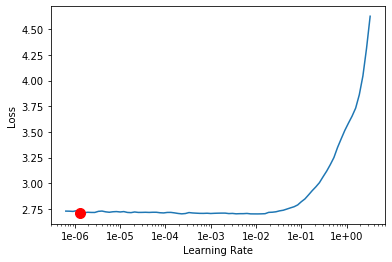

In [38]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [36]:
learner.save('baselinev2-128')

In [37]:
learner.load('baselinev2-128')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [21]:
learner.data = get_data(256)

In [23]:
learner.save('baselinev2-256')

## Pretrained

In [7]:
instructor = cs.SingleInstruction()
c_out = 16
learner = cs.cs_learner(get_data(128), models.resnet18, instructor, td_c=c_out, pretrained=True,
                        loss_func=loss, callback_fns=pose.Pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.29E-01


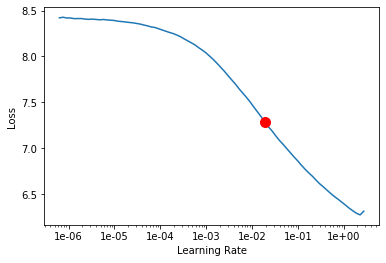

In [25]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [26]:
lr = 3e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.097866,3.841648,0.797084,0.620594,0.464423,0.431735,0.453119,0.446390,0.473141,0.582797,0.534352,01:03
1,3.976435,3.687898,0.813002,0.664535,0.528684,0.484477,0.464774,0.459365,0.492349,0.626626,0.566810,01:03
2,3.874358,3.745656,0.830105,0.681113,0.503738,0.494618,0.452172,0.474756,0.482750,0.631607,0.568901,01:03
3,3.727231,3.466380,0.854162,0.730122,0.618539,0.556644,0.517199,0.506712,0.523376,0.693358,0.625134,01:03
4,3.628429,3.877989,0.863332,0.748129,0.613463,0.538797,0.451068,0.198781,0.257686,0.694760,0.548857,01:03
5,3.521747,3.225345,0.874665,0.776060,0.655458,0.606853,0.561142,0.594724,0.559874,0.731538,0.670261,01:03
6,3.405599,3.126620,0.880177,0.794232,0.691099,0.640095,0.589676,0.609084,0.589172,0.754347,0.693566,01:03
7,3.321985,3.052960,0.888471,0.803206,0.700659,0.647937,0.603890,0.639309,0.615075,0.763000,0.707618,01:03
8,3.225178,3.018742,0.889295,0.811200,0.711056,0.664343,0.614522,0.652339,0.624862,0.771734,0.717290,01:03
9,3.196515,3.008733,0.891304,0.813812,0.710699,0.666244,0.615229,0.653198,0.630238,0.773297,0.719044,01:03


In [27]:
learner.save('baselinev2-128-stage1')

In [39]:
learner.load('baselinev2-128-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [40]:
learner.unfreeze()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.20E-06


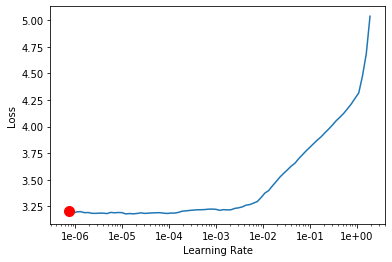

In [30]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [37]:
learner.fit_one_cycle(20, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.207350,3.007453,0.891613,0.812924,0.713031,0.668771,0.615385,0.658226,0.626858,0.774325,0.719974,01:03
1,3.227029,3.011534,0.890068,0.813709,0.711414,0.665825,0.614248,0.655939,0.623543,0.773016,0.718352,01:03
2,3.212544,3.023557,0.890841,0.808074,0.702515,0.660875,0.610799,0.645323,0.614791,0.768396,0.712713,01:03
3,3.220389,3.026373,0.892798,0.811619,0.708444,0.666410,0.611012,0.646705,0.620777,0.772616,0.716163,01:03
4,3.256129,3.044462,0.887029,0.809374,0.698166,0.659180,0.599010,0.639182,0.609002,0.766286,0.708252,01:03
5,3.186917,3.008080,0.892644,0.816163,0.720048,0.667867,0.609706,0.649849,0.623002,0.776902,0.719241,01:03
6,3.160174,2.986812,0.891407,0.823157,0.723125,0.670203,0.619971,0.655801,0.629796,0.779733,0.724008,01:03
7,3.146750,2.972959,0.894189,0.821481,0.722436,0.677618,0.625098,0.661557,0.637320,0.781603,0.727465,01:03
8,3.118945,2.950031,0.896301,0.826916,0.724352,0.679168,0.630339,0.673911,0.644185,0.784381,0.732248,01:03
9,3.075075,2.950006,0.893674,0.830782,0.732687,0.685573,0.624325,0.668635,0.637341,0.788267,0.732347,01:03


In [38]:
learner.save('baselinev2-128-stage2')

In [ ]:
learner.load('baselinev2-128-stage2')

In [ ]:
learner.data = get_data(256)
learner.freeze()

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
lr = 
learner.fit_one_cycle(10, lr)

In [ ]:
learner.save('baselinev2-256-stage1')

In [ ]:
learner.load('baselinev2-256-stage1')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(20, slice(, lr/5))

In [ ]:
learner.save('baselinev2-256-stage2')

In [16]:
lr = 1e-2
learner.fit_one_cycle(40, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.987631,4.647799,0.663816,0.487432,0.291745,0.267620,0.311118,0.252586,0.362038,0.432427,0.383979,01:00
1,4.532515,4.500963,0.734030,0.545255,0.324247,0.303495,0.352838,0.341012,0.410783,0.482132,0.437256,00:59
2,4.326157,3.964130,0.796775,0.644439,0.442088,0.393341,0.422508,0.394485,0.443564,0.574063,0.514645,00:59
3,4.140950,3.875656,0.782506,0.668576,0.493354,0.441134,0.436083,0.442654,0.462080,0.600705,0.541168,00:59
4,4.030505,4.038970,0.782403,0.663064,0.480930,0.452844,0.427617,0.420304,0.458466,0.598996,0.535644,01:00
5,3.891826,3.672553,0.830775,0.686620,0.540898,0.504863,0.475946,0.478994,0.486213,0.644734,0.581480,01:00
6,3.830612,3.655392,0.820626,0.696297,0.548499,0.511501,0.465923,0.490802,0.508279,0.647979,0.585793,01:00
7,3.791111,3.465661,0.849423,0.727908,0.609664,0.549702,0.528624,0.532253,0.534701,0.687749,0.627817,00:59
8,3.707333,3.483002,0.835566,0.728199,0.595639,0.546872,0.527033,0.530554,0.541865,0.680097,0.623397,00:59
9,3.632650,3.416414,0.838038,0.743633,0.614455,0.558049,0.531377,0.551336,0.530738,0.692035,0.632847,01:02


In [22]:
learner.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.010076,4.460857,0.895116,0.826088,0.714836,0.666502,0.539149,0.526341,0.492704,0.778491,0.680107,01:47
1,4.693126,4.243952,0.901556,0.837522,0.741684,0.700417,0.567966,0.573374,0.541758,0.797802,0.707519,01:46
2,4.587859,4.134347,0.908098,0.843684,0.757421,0.719384,0.594488,0.613115,0.578301,0.809487,0.727630,01:47
3,4.499538,4.063585,0.912941,0.851460,0.769138,0.733175,0.605666,0.642911,0.600630,0.818915,0.741262,01:46
4,4.411286,4.011513,0.916237,0.857671,0.778179,0.742338,0.621092,0.665843,0.618764,0.825766,0.752638,01:46
5,4.341698,3.965773,0.917834,0.861011,0.786988,0.750805,0.638017,0.685466,0.644178,0.831214,0.763735,01:46
6,4.295968,3.934826,0.919998,0.863777,0.790943,0.757235,0.645115,0.697651,0.662250,0.834980,0.770592,01:46
7,4.252602,3.929391,0.919483,0.864408,0.787990,0.757593,0.646640,0.703007,0.668316,0.834366,0.771769,01:46
8,4.201268,3.924004,0.918504,0.865711,0.789556,0.761062,0.648773,0.706492,0.682552,0.835675,0.774856,01:46
9,4.175802,3.875288,0.923398,0.872652,0.800480,0.769078,0.660441,0.723590,0.702551,0.843327,0.785624,01:46


## No Instruction

In [3]:
instructor = cs.SingleInstruction()
c_out = 16
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=c_out, pretrained=False, embedding=None,
                        loss_func=loss, callback_fns=pose.Pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 2.29E-01


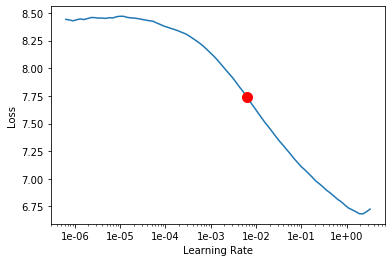

In [4]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [5]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.987977,4.567939,0.683495,0.478782,0.294244,0.254905,0.315764,0.286583,0.360475,0.432868,0.389050,06:52
1,4.549531,4.110280,0.762570,0.578335,0.399623,0.342505,0.380312,0.352551,0.424732,0.525720,0.471205,03:14
2,4.298253,3.896944,0.795642,0.643615,0.472875,0.403170,0.435949,0.412251,0.452081,0.583531,0.525675,01:19
3,4.134832,3.819671,0.803266,0.674983,0.506449,0.436856,0.434030,0.424291,0.455454,0.609853,0.543489,01:10
4,4.006347,3.763578,0.813414,0.678682,0.525978,0.466220,0.457237,0.452192,0.488044,0.625304,0.563493,01:14
5,3.894619,3.585719,0.842263,0.709830,0.560663,0.506625,0.500007,0.507147,0.511502,0.658903,0.600092,01:21
6,3.839085,3.490582,0.848650,0.723591,0.591043,0.533717,0.510717,0.514413,0.528187,0.678053,0.616202,01:11
7,3.766068,3.484401,0.852411,0.739665,0.599669,0.542187,0.521070,0.526004,0.542382,0.687321,0.626451,01:19
8,3.724278,3.485705,0.838553,0.716271,0.576741,0.536975,0.523268,0.539313,0.554926,0.670775,0.619602,01:23
9,3.646555,3.395620,0.853699,0.730408,0.607502,0.572667,0.535071,0.551279,0.546382,0.694479,0.636568,01:08


In [6]:
learner.save('baselinev2-noinst-128')

In [7]:
learner.load('baselinev2-noinst-128')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.10E-03


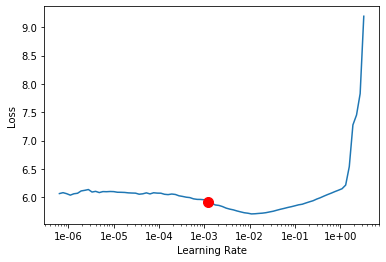

In [9]:
learner.data = pose.get_data(root, 256)
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
learner.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.941670,4.420929,0.892026,0.821754,0.722644,0.671100,0.546777,0.537996,0.492197,0.779613,0.683367,03:08
1,4.679213,4.230792,0.901504,0.838984,0.745959,0.703098,0.572372,0.588496,0.539368,0.799872,0.711108,03:29
2,4.542892,4.126417,0.905934,0.845043,0.759313,0.725105,0.595015,0.622614,0.570308,0.811103,0.729046,02:29
3,4.457860,4.054231,0.912528,0.851726,0.768679,0.735720,0.610613,0.646067,0.604391,0.819356,0.743081,02:34
4,4.401666,3.998146,0.916237,0.856684,0.777229,0.745759,0.627315,0.670893,0.628233,0.826086,0.755421,02:23
5,4.344970,3.958867,0.919019,0.861594,0.782414,0.750810,0.634675,0.686992,0.648472,0.830547,0.763472,02:22
6,4.259744,3.924481,0.919380,0.864202,0.790210,0.758517,0.644500,0.698910,0.664102,0.835074,0.770913,02:10
7,4.221149,3.915584,0.918401,0.864149,0.790968,0.760184,0.650776,0.712075,0.685247,0.835381,0.775968,02:29
8,4.202864,3.888808,0.922265,0.867751,0.797939,0.765574,0.657716,0.719200,0.692955,0.840309,0.781771,02:38
9,4.167010,3.866821,0.921080,0.869472,0.801635,0.769563,0.664977,0.726153,0.703807,0.842312,0.786134,02:16
